## Modified Slim

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt
import deepxde as dde

######################
# ITER shape #
######################
eps = 0.32
kappa = 1.7
delta = 0.33
Amax = 1e-5

N1 = - (1 + np.arcsin(delta)) ** 2 / (eps * kappa ** 2)
N2 = (1 - np.arcsin(delta)) ** 2 / (eps * kappa ** 2)
N3 = - kappa / (eps * np.cos(np.arcsin(delta)) ** 2)

def gen_traindata(num):
    ######################
    # ITER Configuration #
    ######################

    N = num
    center = np.array([[0.0,0.0,0.0]])
    tau = np.linspace(0, 2 * np.pi, N)
    num_A = 1
    Arange = np.linspace(-Amax, Amax, num_A)
    # Define boundary of ellipse
    #x_ellipse = np.asarray([1 + eps * np.cos(tau + np.arcsin(delta) * np.sin(tau)), 
    #                eps * kappa * np.sin(tau), Arange]).T
    
    R_ellipse = np.outer(1 + eps * np.cos(tau + np.arcsin(delta) * np.sin(tau)),
                             np.ones(num_A)
                             )
    Z_ellipse = np.outer(eps * kappa * np.sin(tau),
                             np.ones(num_A)
                             )
    A_ellipse = np.outer(np.ones(N), Arange)
    x_ellipse = np.transpose(np.asarray([R_ellipse, Z_ellipse, A_ellipse]), [1, 2, 0])
    x_ellipse = x_ellipse.reshape(N * num_A, 3)

    print(x_ellipse.shape)
    uvals = np.zeros(len(x_ellipse)).reshape(len(x_ellipse), 1)
    return x_ellipse, uvals


def pde_solovev(x, u):
    psi = u[:, 0:1]
    psi_r = dde.grad.jacobian(psi, x, i=0, j=0)
    psi_rr = dde.grad.hessian(psi, x, i=0, j=0)
    psi_zz = dde.grad.hessian(psi, x, i=1, j=1)
    A = x[:, 2:3]
    GS = psi_rr - psi_r / x[:, 0:1] + psi_zz - (1 - A) * x[:, 0:1] ** 2 - A
    return GS

def psi_r(x,u):
    return dde.grad.jacobian(u, x, i=0, j=0)
def psi_z(x,u):
    return  dde.grad.jacobian(u, x, i=0, j=1)
def psi_rr(x, u):
    return dde.grad.hessian(u, x, i=0, j=0)
def psi_zz(x, u):
    return dde.grad.hessian(u, x, i=1, j=1)

def boundary_outer(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 + eps, 0]).all()
def boundary_inner(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 - eps, 0]).all()
def boundary_high(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 - delta * eps, kappa * eps]).all()

spatial_domain = dde.geometry.Ellipse_A(eps, kappa, delta, Amax=Amax) 

x, u = gen_traindata(200)

n_test = 100
x_test,u_test = gen_traindata(n_test)
x_domain = spatial_domain.random_points(n_test)
x_test = np.concatenate((x_test, x_domain))
u_test = np.concatenate((u_test, np.zeros((n_test, 1))))

bc135 = dde.PointSetBC(x,u)

data = dde.data.PDE(
    spatial_domain,
    pde_solovev,
    [bc135],
    num_domain=2048,
    num_boundary=0,
    x_test=x_test,
    y_test=u_test,
    train_distribution="LHS"
)


Using TensorFlow 2 backend.

Instructions for updating:
non-resource variables are not supported in the long term
(200, 3)
(100, 3)


In [2]:
data.train_x_bc.shape

(200, 3)

Text(0.5, 0, '$u(r,z=0)$')

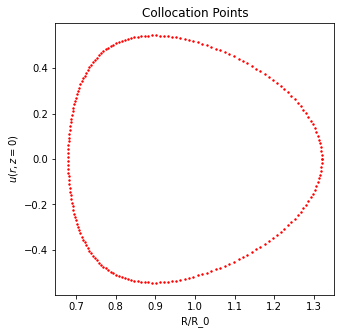

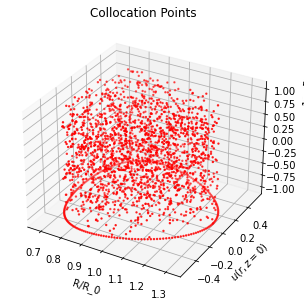

In [3]:
# Plot collocation points for visual check
# %matplotlib

fig,ax=plt.subplots(1, figsize=(5,5))
ax.scatter(data.train_x_bc[:,0], data.train_x_bc[:,1], s = 2, color='r')
ax.set_title('Collocation Points')
ax.set_xlabel('R/R_0')
ax.set_ylabel(r'$u(r,z=0)$')

fig =plt.figure(2, figsize=(5,5))
ax = fig.add_subplot(projection='3d')
ax.scatter(data.train_x[:,0], data.train_x[:,1], data.train_x[:,2], s = 2, color='r')
ax.set_title('Collocation Points')
ax.set_xlabel('R/R_0')
ax.set_ylabel(r'$u(r,z=0)$')

In [4]:
from utils.gs_solovev_sol import GS_Linear
# tokamak = GS_Linear(A=-0.155, eps= 2/6.2, kappa=1.6, delta=0.4)

## Train Model

Compiling model...
Building feed-forward neural network...
'build' took 0.071206 s



/Users/alankaptanoglu/deepxde_copy/deepxde/maps/fnn.py:112: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,


'compile' took 1.458088 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [9.42e-01, 3.76e-03]    [9.87e-01, 0.00e+00]    []  
10        [1.60e-01, 1.33e-02]    [2.30e-01, 0.00e+00]    []  
20        [7.62e-02, 8.17e-03]    [1.13e-01, 0.00e+00]    []  
30        [2.63e-02, 7.44e-03]    [5.11e-02, 0.00e+00]    []  
40        [4.72e-03, 2.34e-03]    [7.56e-03, 0.00e+00]    []  
50        [2.13e-03, 1.39e-03]    [4.29e-03, 0.00e+00]    []  
60        [1.12e-03, 5.41e-04]    [2.42e-03, 0.00e+00]    []  
70        [5.27e-03, 5.18e-04]    [4.34e-03, 0.00e+00]    []  
80        [1.02e-03, 3.06e-04]    [1.11e-03, 0.00e+00]    []  
90        [1.45e-03, 2.92e-04]    [2.05e-03, 0.00e+00]    []  
100       [3.56e-04, 2.17e-04]    [4.08e-04, 0.00e+00]    []  

Best model at step 100:
  train loss: 5.73e-04
  test loss: 4.08e-04
  test metric: []

'train' took 3.997960 s

Saving loss history to ./cefron/ITER/runs/network_s

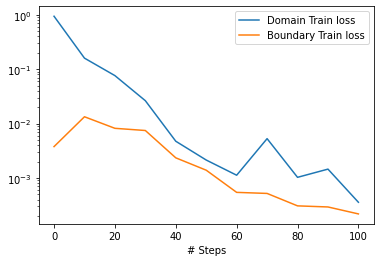

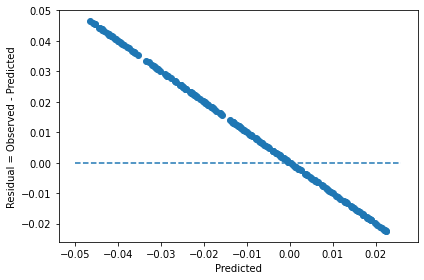

In [5]:
#[0.02,0.007,0.002,0.0007,0.0002]
import os
DATE = "10122022"
CONFIG = "ITER"
LR = 2e-2
DEPTH = 3
BREADTH = 40
run = "01_100Adam_BFGS"
AF = "swish"
RUN_NAME = f"network_sweep_{DATE}_depth0{DEPTH}_breadth{BREADTH}_{AF}_lr{LR}-varying-short_lw1-10_{run}"

PATH = f"./cefron/{CONFIG}/runs/{RUN_NAME}"
# Check whether the specified path exists or not
isExist = os.path.exists(PATH)
if not isExist:
  # Create a new directory because it does not exist 
  os.makedirs(PATH)
  print("The new directory is created!")

net = dde.maps.FNN([3] + DEPTH * [BREADTH] + [1], AF, "Glorot normal")

model = dde.Model(data, net)
decay_rate = 1.0
for i in range(1):
  # Compile, train and save model
  model.compile(
      "adam", lr=LR/(decay_rate*(i+1)),
      loss_weights=[1,1]
  )
  loss_history, train_state = model.train(epochs=100, display_every = 10)
  dde.saveplot(loss_history, train_state, save_plot=True,issave=True, isplot=True,output_dir=f'./cefron/{CONFIG}/runs/{RUN_NAME}')

#### After BFGS

Compiling model...
'compile' took 2.839760 s

Training model...

Step      Train loss              Test loss               Test metric
100       [3.56e-04, 2.17e-02]    [4.08e-04, 0.00e+00]    []  
110       [2.84e-03, 5.68e-03]                                
120       [2.56e-04, 1.25e-03]                                
130       [1.77e-04, 1.09e-03]                                
140       [1.82e-04, 8.00e-04]                                
150       [3.23e-04, 4.18e-04]                                
160       [1.73e-04, 5.30e-04]                                
170       [3.07e-04, 1.96e-04]                                
180       [2.64e-04, 1.18e-04]                                
190       [3.09e-04, 4.31e-05]                                
200       [3.22e-04, 2.41e-04]                                
210       [2.47e-04, 3.29e-05]                                
220       [8.16e-05, 2.15e-05]                                
230       [5.21e-05, 1.35e-05]                

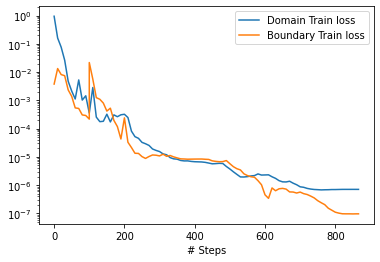

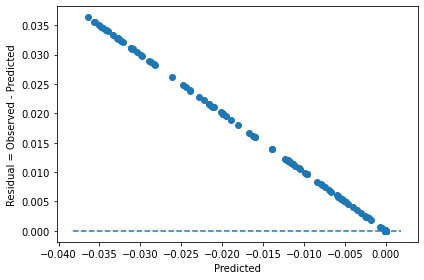

In [6]:
# Compile, train and save model
model.compile(
    "L-BFGS-B",
    loss_weights=[1,100]
)
loss_history, train_state = model.train(epochs=1000, display_every = 10)
dde.saveplot(loss_history, train_state, save_plot=True,issave=True, isplot=True,output_dir=f'./cefron/{CONFIG}/runs/{RUN_NAME}')


In [7]:
# Evaluation
from utils.utils import evaluate_A, relative_error_plot
ITER = GS_Linear(eps=eps, kappa=kappa, delta=delta)
xfull,yfull,A,psi_pred_full,psi_true_full,error=evaluate_A(ITER, model, Amax)
# X_test = spatial_domain.random_points(300)


(26010, 3)
(2000, 3)


[[0.02549735 0.02483906 0.02420756 ... 0.02420756 0.02483906 0.02549735]
 [0.0243489  0.0235622  0.02280636 ... 0.02280636 0.0235622  0.0243489 ]
 [0.02325902 0.02234    0.02145609 ... 0.02145609 0.02234    0.02325902]
 ...
 [0.18693098 0.17449345 0.16250553 ... 0.16250553 0.17449345 0.18693098]
 [0.19904822 0.18621229 0.17384113 ... 0.17384113 0.18621229 0.19904822]
 [0.21172034 0.19847839 0.18571669 ... 0.18571669 0.19847839 0.21172034]] [[0.0254977  0.0248394  0.02420787 ... 0.02420787 0.0248394  0.0254977 ]
 [0.02434923 0.0235625  0.02280664 ... 0.02280664 0.0235625  0.02434923]
 [0.02325931 0.02234028 0.02145635 ... 0.02145635 0.02234028 0.02325931]
 ...
 [0.18693022 0.17449272 0.16250484 ... 0.16250484 0.17449272 0.18693022]
 [0.19904736 0.18621147 0.17384035 ... 0.17384035 0.18621147 0.19904736]
 [0.21171938 0.19847747 0.18571581 ... 0.18571581 0.19847747 0.21171938]] 10


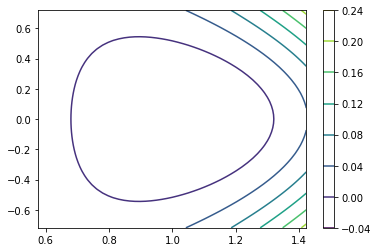

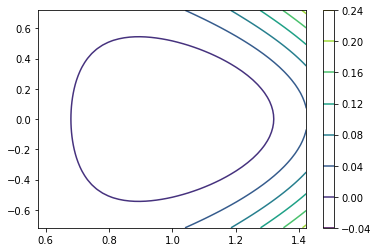

In [8]:
print(psi_true_full[:, :, 0], psi_true_full[:, :, -1], xfull.shape[2])
plt.figure()
plt.contour(xfull[:, :, 0], yfull[:, :, 0], psi_true_full[:, :, 0])
plt.colorbar()
plt.figure()
plt.contour(xfull[:, :, 0], yfull[:, :, 0], psi_pred_full[:, :, 0])
plt.colorbar()

0
5


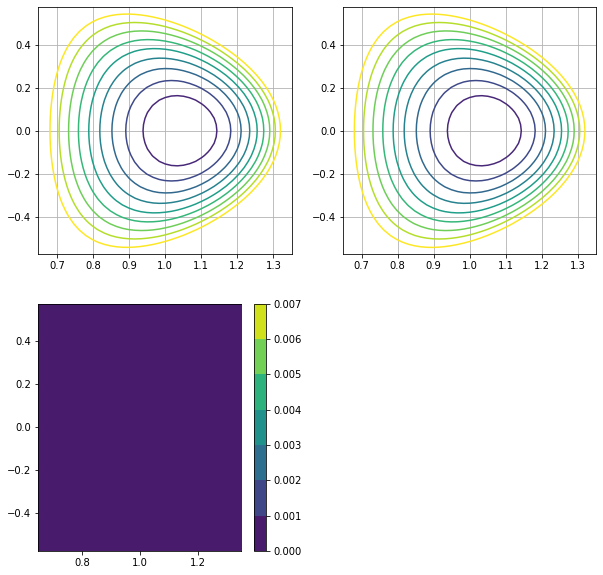

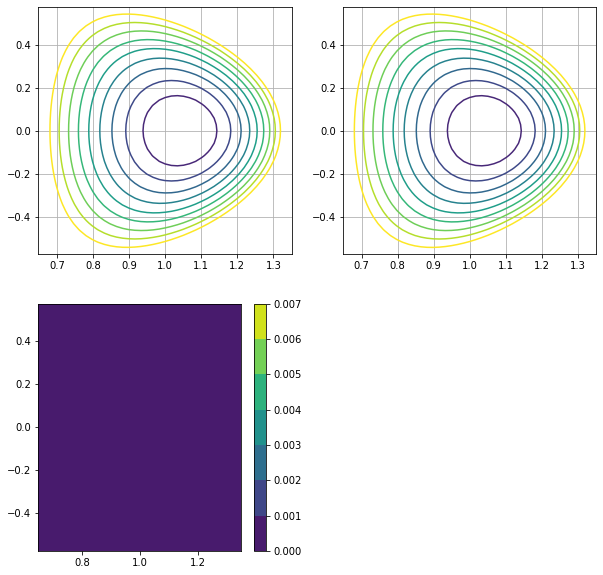

In [9]:
# Plotting Setup
zoom = ((1 + eps)-(1 - eps))*0.05
innerPoint = 1 - eps - zoom
outerPoint = 1 + eps + zoom
lowPoint   = -kappa * eps - zoom
highPoint  = kappa * eps + zoom

for i in range(0, xfull.shape[2], 5):
    print(i)
    plt.figure(i + 1, figsize=(10,10))

    levels = np.linspace(min(psi_true_full[:, :, i].reshape(-1)),0,10)
#     print(levels)
    
    plt.subplot(2, 2, 1)
    # Plot 1 - PINN Solution
    cp = plt.contour(xfull[:, :, i], yfull[:, :, i], psi_pred_full[:, :, i],levels=levels)
    # ax1.scatter(observe_x[:,0], observe_x[:,1], s = 2,c="black")
    #plt.colorbar(cp,ax=ax1).formatter.set_powerlimits((0, 0)) 
    #ax1.set_title('PINN Solution')
    #ax1.set_xlabel(r'$R/R_{0}$')
    #ax1.set_ylabel(r'$Z/R_{0}$')
    plt.grid(True)
    plt.axis(xmin=innerPoint,xmax=outerPoint,ymin=lowPoint, ymax=highPoint)

    # Plot 2 - Analytic Solution
    plt.subplot(2, 2, 2)
    cp = plt.contour(xfull[:, :, i], yfull[:, :, i], psi_true_full[:, :, i],levels=levels)
    #plt.colorbar(cp,ax=ax2).formatter.set_powerlimits((0, 0))
    #ax2.set_title('Analytical Solution')
    #ax2.set_xlabel(r'$R/R_{0}$')
    #ax2.set_ylabel(r'$Z/R_{0}$')
    plt.grid(True)
    plt.axis(xmin=innerPoint,xmax=outerPoint,ymin=lowPoint, ymax=highPoint)

    # Plot 4 - Relative Error
    plt.subplot(2, 2, 3)
    cp = plt.contourf(xfull[:, :, i], yfull[:, :, i], error[:, :, i])  #,levels=levels)
    #fig.colorbar(cp,ax=ax3).formatter.set_powerlimits((0, 0))
    #ax2.set_title('Analytical Solution')
    #ax3.set_xlabel(r'$R/R_{0}$')
    #ax3.set_ylabel(r'$Z/R_{0}$')
    plt.axis(xmin=innerPoint,xmax=outerPoint,ymin=lowPoint, ymax=highPoint)
    plt.colorbar()

    fig.tight_layout()
    #plt.savefig(f'./cefron/{CONFIG}/runs/{RUN_NAME}/analysis_after_BFGS_A' + str(A[0, 0, i]) + ' .jpg')



In [10]:
n = 100
theta = np.linspace(0, 2 * np.pi, n)
Arange = np.linspace(-Amax, Amax, n)
R_ellipse = np.outer(1 + eps * np.cos(theta + np.arcsin(delta) * np.sin(theta)),
                             np.ones(n)
                             )
Z_ellipse = np.outer(eps * kappa * np.sin(theta),
                             np.ones(n)
                             )
A_ellipse = np.outer(np.ones(n), Arange)
RA = np.outer(1 + eps * np.cos(theta + np.arcsin(delta)), Arange)
ZA = np.outer(eps * kappa * np.sin(theta), Arange)
RZA = np.transpose(np.stack((RA, ZA)), [1, 2, 0])
x_ellipse = np.transpose(np.asarray([R_ellipse, Z_ellipse, A_ellipse]), [1, 2, 0])
print(RZA.shape)
X = np.hstack((R_ellipse, Z_ellipse, A_ellipse))
X.shape

(100, 100, 2)


(100, 300)

In [11]:
X = np.hstack((1 + eps * np.cos(theta + np.arcsin(delta) * np.sin(theta)) ,
                       eps * kappa * np.sin(theta)))
X.shape

(200,)

In [12]:
spatial_domain.x_ellipse.shape

(1000, 3)

In [13]:
R, A = np.meshgrid(1 + eps * np.cos(theta + np.arcsin(delta)), 
            Arange, indexing='ij')

In [14]:
RZA = np.outer()

TypeError: _outer_dispatcher() missing 2 required positional arguments: 'a' and 'b'

In [ ]:
        R_ellipse = np.outer(1 + eps * np.cos(tau + np.arcsin(delta) * np.sin(self.tau)),
                             np.ones(10)
                             )
        Z_ellipse = np.outer(self.eps * self.kappa * np.sin(self.tau),
                             np.ones(self.num_A)
                             )
        A_ellipse = np.outer(np.ones(self.N), Arange)
